In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import sys
from scipy import stats
%matplotlib inline

# Problem specific libarires:
import scipy.signal as sig
import Incline_Module as im
from ExternalFunctions import nice_string_output, add_text_to_ax

### Data importing

In [2]:
# Creating dictionaries:
# RIGHT = NORMAL, LEFT = REVERSED
t_right_dict = {} # NOTE: Time-data is measured in seconds
V_right_dict = {}
t_left_dict = {}
V_left_dict = {}

# Importing oscilloscope data:
for i in range(5):
    data_right = np.genfromtxt('forsøg'+str(i+1)+'_bigball_right.csv', delimiter=',', skip_header=15, dtype=float)
    data_left = np.genfromtxt('forsøg'+str(i+1)+'_bigball_left.csv', delimiter=',', skip_header=15, dtype=float)
    t_right, V_right = data_right[:, 0], data_right[:, 1]
    t_left, V_left = data_left[:, 0], data_left[:, 1]                          
    t_right_dict[i], V_right_dict[i] = t_right, V_right 
    t_left_dict[i], V_left_dict[i]= t_left, V_left

# Gate positions
# Order: Chamilla, Daniel, Emil, Sejr, Julius
s_data = np.array([[130, 273, 416, 558, 700],
                   [129, 271, 414, 556, 700],
                   [129, 271, 415, 557, 700],
                   [135, 276, 420, 562, 705],
                   [130, 271, 416, 558, 701]])*1E-3 # Unit conversion mm -> m
s_sigma = 4E-3 # 4mm error on datapoints

# Rail-width (HAS TO BE DIVIDED BY TWO IN THE ERROR PROPAGATION TERM)
d_data = np.array([5.9, 6.0, 5.9, 5.8, 5.7])*1E-3
d_sigma = 0.1E-3 # 0.1 mm error on datapoints

# Ball diameter (BIG BALL):
# Divided by two to get ball radius
R_data = np.array([15.7, 15.8, 15.9, 15.9, 15.9])*(1E-3/2)
R_sigma = 0.05*(1E-3) # 0.05mm equipment resolution (error on datapoints)

# Angle measurements (GONIOMETER):
# For(ward)/Back(ward) refer to goniometer orientation
# Normal/reversed refer to setup orientation
theta_gonio_for_norm = np.radians(np.array([74, 74, 76, 74.5, 74]))
theta_gonio_back_norm = np.radians(np.array([76, 77.5, 75, 76.5, 76.5]))
theta_gonio_for_rev = np.radians(np.array([77, 78, 77, 77, 75.5]))
theta_gonio_back_rev = np.radians(np.array([75.5, 76, 74, 75, 76.5]))

# Angle measurements (TRIGONOMERTY)
# Hight measurement (modstoende katete)
h_data = np.array([23.4, 23.75, 23.8, 23.8, 23.8])*1E-2

# Base measurements (hosliggende katete)
l_data = np.array([88.5, 88.5, 88.3, 88.3, 88.4])*1E-2 # Conversion cm -> m

hl_sigma = 1E-3 # 1mm error on each data-point

### $d$- and $R$-results

In [3]:
d, derr, *infod = im.wmean(d_data, d_sigma)
R, Rerr, *infoR = im.wmean(R_data, R_sigma)

print(d, derr, *infod)
print(R, Rerr, *infoR)

print(np.mean(d_data), np.std(d_data))
print(np.mean(R_data), np.std(R_data))

0.0293 0.0001 274721.99999999994 0.0
0.0396 5e-05 2007248.0000000005 0.0
0.005860000000000001 0.00010198039027185583
0.00792 4.000000000000036e-05


### Acceleration (right) results
For each experiment, we get two accelerations, $a_{norm} \pm \sigma_{a_{norm}}$ and $a_{rev} \pm \sigma_{a_{rev}}$. Each member theier measurements through a WM and a SEWM, and galculate the final $g$.

In [4]:
# Identifying peaks
N = len(t_right_dict)
t_right = {}
terr_right = {}

for i in range(N):
    t, V = t_right_dict[i], V_right_dict[i]
    t_right[i], terr_right[i] = im.peak_finder(t, V, trigger_val = 3, plotting = False)
    
# Identifying peaks
N = len(t_left_dict)
t_left = {}
terr_left = {}

for i in range(N):
    t, V = t_left_dict[i], V_left_dict[i]
    t_left[i], terr_left[i] = im.peak_finder(t, V, trigger_val = 3, plotting = False)

In [17]:
# Fitting to parabola
# Defining needed functions
def s_func(t, s0, v0, a):
    return s0 + v0*t + 0.5*a*(t**2)

def chi2_s(t, s , serr, s0, v0, a): 
    s_fit = s_func(t, s0, v0, a)
    chi2 = np.sum(((s - s_fit) / serr)**2)
    return chi2

Minuit.print_level = 0 

def acceleration(t_data, s, s_sigma = 4E-3, v0 = 0, a = 2):

    acc_array = []
    aerr_array = []
    a_chi2 = {}
    a_p = {}
    
    for i in range(N):
        minimize_obj = lambda s0, v0, a: chi2_s(t_data[i], s[i], s_sigma, s0, v0, a) 
        # Define a object to minimze (coul create issues since s_sigma is not a np.array)

        # Fitting
        minimize_obj.errordef = Minuit.LEAST_SQUARES
        minuit_fit = Minuit(minimize_obj, s0 = s[i][0], v0 = v0, a = a)     
        minuit_fit.migrad()                            

        # Extracting and saving parameters:
        params, errors, chi2, Ndof, chi2p = im.extract(minuit_fit, t_data[i], display = False)

        acc_array.append(params[2]) 
        aerr_array.append(errors[2])
        a_chi2[i] = chi2
        a_p[i] = chi2p

    acc_array, aerr_array = np.array(acc_array), np.array(aerr_array)
    acc, aerr, *info = im.wmean(acc_array, aerr_array)
    
    print('Acceleration:', acc, '+/-', aerr)

    return acc, aerr
       
acc_right, aerr_right = acceleration(t_right, s_data)
acc_right, aerr_right = acceleration(t_left, s_data)

Acceleration: 1.6878210572504297 +/- 0.06431016348758146
Acceleration: 1.73738761902274 +/- 0.06739684042716636


### Acceleration (left) results

In [7]:
# Fitting to parabola
# Creating dictionaries and container-arrays
a_left_array = []
aerr_left_array = []
a_chi2_left = {}
a_p_left = {}

# Defining needed functions
def s_func(t, s0, v0, a):
    return s0 + v0*t + 0.5*a*(t**2)

def chi2_s(t,s,serr,s0, v0, a): 
    s_fit = s_func(t, s0, v0, a)
    chi2 = np.sum(((s - s_fit) / serr)**2)
    return chi2

Minuit.print_level = 0 

for i in range(N):
    minimize_obj = lambda s0, v0, a: chi2_s(t_left[i], s_data[i], s_sigma, s0, v0, a) #Define a object to minimze (coul create issues since s_sigma is not a np.array)

    # Fitting
    minimize_obj.errordef = Minuit.LEAST_SQUARES
    minuit_fit = Minuit(minimize_obj, s0=s_data[i][0], v0=0, a=2)     
    minuit_fit.migrad()                            

    # Extracting and saving parameters:
    params, errors, chi2, Ndof, chi2p = im.extract(minuit_fit, t_left[i], display=False)

    a_left_array.append(params[2]) 
    aerr_left_array.append(errors[2])
    a_chi2_left[i] = chi2
    a_p_left[i] = chi2p

a_left_array, aerr_left_array = np.array(a_left_array), np.array(aerr_left_array)
a_left, aerr_left, *info = im.wmean(a_left_array, aerr_left_array)

print('acceleration, left =',a_left,'+-' , aerr_left)
print(info, 'a quite concerning chi2')

acceleration, left = 1.73738761902274 +- 0.06739684042716636
[0.11019498965434013, 0.998536751583005] a quite concerning chi2


## $\theta$-calculation
Procedure:

* Estimate $\Delta \theta$ through goniometer measurements: $\Delta \theta = \frac{\theta_{gonio, norm}-\theta_{gonio, rev}}{2}$
* Estimate $\Delta \theta$ through trig measurements: $\Delta \theta = \frac{a_{norm}-a_{rev}}{a_{norm}+a_{rev}} \tan(\theta_{trig})$
* Take the mean and std of the two $\Delta \theta$, to get $\Delta \theta \pm \sigma_{\Delta \theta}$
* Define $\theta_{trig, norm} =\theta_{trig} + \Delta \theta$ and $\theta_{trig, rev} =\theta_{trig} - \Delta \theta$. Get errors on them by error propagation
* Combine $\theta_{trig, norm}$ and $\theta_{gonio, norm}$ (and likewise for the reversed direction) to get $\theta_{total, norm} \pm \sigma_{\theta_{total, norm}}$ (and likewise for the reversed direction)

In [8]:
def theta_cal(theta_for, theta_back):
    theta_gonio, thetaerr_gonio = [], []
    
    for i in range(5):
        mu = np.mean([theta_for[i],theta_back[i]])
        sigma = (1/np.sqrt(2)) * np.std([theta_for[i],theta_back[i]])

        theta_gonio.append(mu)
        thetaerr_gonio.append(sigma)
    
    theta_gonio, thetaerr_gonio = np.array(theta_gonio), np.array(thetaerr_gonio)
    
    return theta_gonio, thetaerr_gonio

In [9]:
# Theta norm (gonio)
theta_gonio_norm, thetaerr_gonio_norm = theta_cal(theta_gonio_for_norm, theta_gonio_back_norm)
print('Theta gonio (norm):', np.radians(90 - np.degrees(theta_gonio_norm)), 'radians')
print('Theta gonio (norm) error:', thetaerr_gonio_norm, 'radians')

print('')
print('')

# Theta rev (gonio)
theta_gonio_rev, thetaerr_gonio_rev = theta_cal(theta_gonio_for_rev, theta_gonio_back_rev)
print('Theta gonio (rev):', np.radians(90 - np.degrees(theta_gonio_rev)), 'radians')
print('Theta gonio (rev) error:', thetaerr_gonio_rev, 'radians')

print('')
print('')

theta_trig = np.arctan(h_data/l_data)
theta_trig_err = np.sqrt( ((h_data / (h_data**2 + l_data**2))**2 * hl_sigma**2) + 
                          ((-h_data / (h_data**2 + l_data**2))**2 * hl_sigma**2) )
print('Theta trig:', theta_trig, 'radians')
print('Theta trig error:', theta_trig_err, 'radians')

Theta gonio (norm): [0.26179939 0.24870942 0.25307274 0.25307274 0.25743606] radians
Theta gonio (norm) error: [0.01234134 0.02159735 0.00617067 0.01234134 0.01542668] radians


Theta gonio (rev): [0.23998277 0.2268928  0.25307274 0.2443461  0.2443461 ] radians
Theta gonio (rev) error: [0.00925601 0.01234134 0.01851201 0.01234134 0.00617067] radians


Theta trig: [0.25849135 0.26218411 0.26327901 0.26327901 0.26299473] radians
Theta trig error: [0.00039491 0.00040003 0.00040245 0.00040245 0.0004016 ] radians


In [10]:
# Weighted mean
theta_norm_mean = im.wmean(np.radians(90 - np.degrees(theta_gonio_norm)),
                           thetaerr_gonio_norm)
print('Theta norm mean:', theta_norm_mean)
print('Theta norm mean (degrees):', theta_norm_mean[0]*(180/np.pi))
print('Theta norm mean error (degrees):', theta_norm_mean[1]*(180/np.pi))

print('')

theta_rev_mean = im.wmean(np.radians(90 - np.degrees(theta_gonio_rev)),
                           thetaerr_gonio_rev)
print('Theta rev mean:', theta_rev_mean)
print('Theta rev mean (degrees):', theta_rev_mean[0]*(180/np.pi))
print('Theta rev mean error (degrees):', theta_rev_mean[1]*(180/np.pi))

print('')

theta_trig_mean = im.wmean(theta_trig, theta_trig_err)
print('Theta trig mean:', theta_trig_mean)
print('Theta trig mean (degrees):', theta_trig_mean[0]*(180/np.pi))
print('Theta trig mean error (degrees):', theta_trig_mean[1]*(180/np.pi))

Theta norm mean: (0.2545217288546663, 0.0046757802783652085, 0.5247832200609491, 0.9710439151486029)
Theta norm mean (degrees): 14.583020857745483
Theta norm mean error (degrees): 0.26790247588083166

Theta rev mean: (0.241751686931647, 0.004303955423134274, 2.0810810810810754, 0.7208488544220821)
Theta rev mean (degrees): 13.851351351351353
Theta rev mean error (degrees): 0.2465984809580363

Theta trig mean: (0.2620196560976413, 0.00017900065245660053, 105.47272884724931, 6.71670409339539e-22)
Theta trig mean (degrees): 15.01262044386411
Theta trig mean error (degrees): 0.010255981915851262


### Plotting

Text(0.5, 0.06, 'Time [s]')

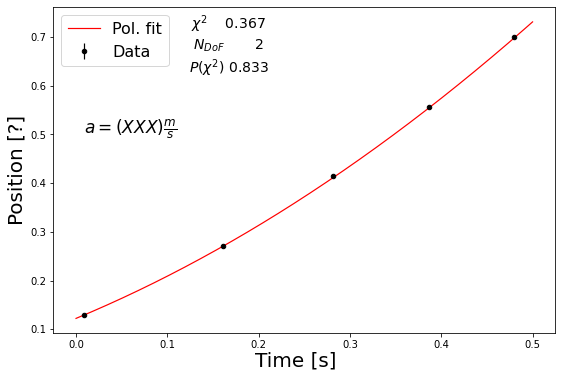

In [11]:
x_fit = np.linspace(0, 0.5, 500)
y_fit = s_func(x_fit, *minuit_fit.values)

Chi2_value = minuit_fit.fval
Ndof = len(t_left[1]) - len(minuit_fit.values[:])
Chi2_prob = stats.chi2.sf(Chi2_value, Ndof)

d = {r'$\chi^2$':       Chi2_value,
     r'$N_{DoF}$':      Ndof,
     r'$P(\chi^2)$':    Chi2_prob}

# Plotting
fig,ax = plt.subplots(1, 1, figsize = (9,6))

# Nice text
text = nice_string_output(d, extra_spacing = 1, decimals = 3)
plt.text(0.35, 0.98, text, fontsize = 14, ha = 'center', va = 'top', transform = ax.transAxes)
plt.text(0.009,0.5,r'$a=(XXX) \frac{m}{s}$',fontsize = 17, c = 'black')

# Fit
ax.errorbar(t_left[1], s_data[1] , yerr = s_sigma, fmt='k.', elinewidth = 1.2, ms = 9, label = 'Data')
ax.plot(x_fit, y_fit, label = 'Pol. fit', c = 'r', lw = 1.2)
ax.set_ylabel('Position [?]', fontsize = 20)
ax.legend(fontsize = 16, loc = "upper left")
fig.text(0.5, 0.06, 'Time [s]', ha = 'center', va = 'center', fontsize = 20)

## Calculation of $g$ (remember, we should get two different estimates, one for the reversed and one for the normal orientation)

In [12]:
def g(a, theta, R, d):
    return 1

def gerr(a, theta, R, d, a_err, theta_err, R_err, d_err):
    return 1